# Preparação de Dados
Faça o download do dataset UCI HAR.

Carregue os dados em Python.

Identifique número de amostras, atributos e classes.


In [18]:
!pip install --upgrade bottleneck --break-system-packages



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install -r "C:\\Users\\walis\\Documents\\Facul\\Redu-o-de-Dimensionalidade-na-Base-UCI-HAR\\UCI HAR Dataset\\requirements.txt"


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'C:\\\\Users\\\\walis\\\\Documents\\\\Facul\\\\Redu-o-de-Dimensionalidade-na-Base-UCI-HAR\\\\UCI HAR Dataset\\\\requirements.txt'

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
# Caminho base para o dataset
dataset_path = "C:\\Users\\walis\\Documents\\Facul\\Redu-o-de-Dimensionalidade-na-Base-UCI-HAR\\UCI HAR Dataset\\requirements.txt"
# dataset_path = 'C:\\Users\\walis\\Documents\\Facul\\Redu-o-de-Dimensionalidade-na-Base-UCI-HAR\\UCI HAR Dataset'


In [50]:

# Features
features = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/features.txt'), 
                       sep=r'\s+', header=None, names=['id','name'])
feature_names = features['name'].tolist()

# Labels das atividades
activity_labels = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/activity_labels.txt'), 
                              sep=r'\s+', header=None, names=['id','label'])
class_names = activity_labels['label'].tolist()

# Carregar dados de treino
X_train = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/train/X_train.txt'), 
                      sep=r'\s+', header=None)
y_train = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/train/y_train.txt'), 
                      sep=r'\s+', header=None)

# Carregar dados de teste
X_test = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/test/X_test.txt'), 
                     sep=r'\s+', header=None)
y_test = pd.read_csv(os.path.join(dataset_path, 'UCI HAR Dataset/test/y_test.txt'), 
                     sep=r'\s+', header=None)

# Combinar dados
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Checar consistência
assert X.shape[1] == len(feature_names), "Número de colunas de X diferente do número de features!"

# Atribuir nomes
X.columns = feature_names

# Informações
print("Número de amostras:", X.shape[0])
print("Número de atributos:", X.shape[1])
print("Número de classes:", len(class_names))
print("Classes:", class_names)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\walis\\Documents\\Facul\\Redu-o-de-Dimensionalidade-na-Base-UCI-HAR\\UCI HAR Dataset\\requirements.txt\\UCI HAR Dataset/features.txt'

# Pré-processamento
Normalize os dados utilizando StandardScaler (importante para o PCA).

Separe os dados em atributos (X) e rótulos (y) (PCA).

In [ ]:

# Inicializa o StandardScaler
scaler = StandardScaler()

# Normaliza os atributos (X)
X_scaled = scaler.fit_transform(X)

# X_scaled será usado para PCA
print("Shape dos dados normalizados:", X_scaled.shape)

# y já está separado e pronto para uso
print("Shape dos rótulos:", y.shape)

Shape dos dados normalizados: (10299, 561)
Shape dos rótulos: (10299, 1)


# Redução de Dimensionalidade com PCA

Aplique o PCA para reduzir os 561 atributos para 2 componentes principais.

Visualize os dados em um gráfico de dispersão 2D, colorindo cada ponto de acordo com a atividade (classe).

Calcule a variância explicada pelos componentes principais.

Determine quantos componentes são necessários para explicar pelo menos 90% da variância.

Variância explicada pelos 2 componentes: 0.5698


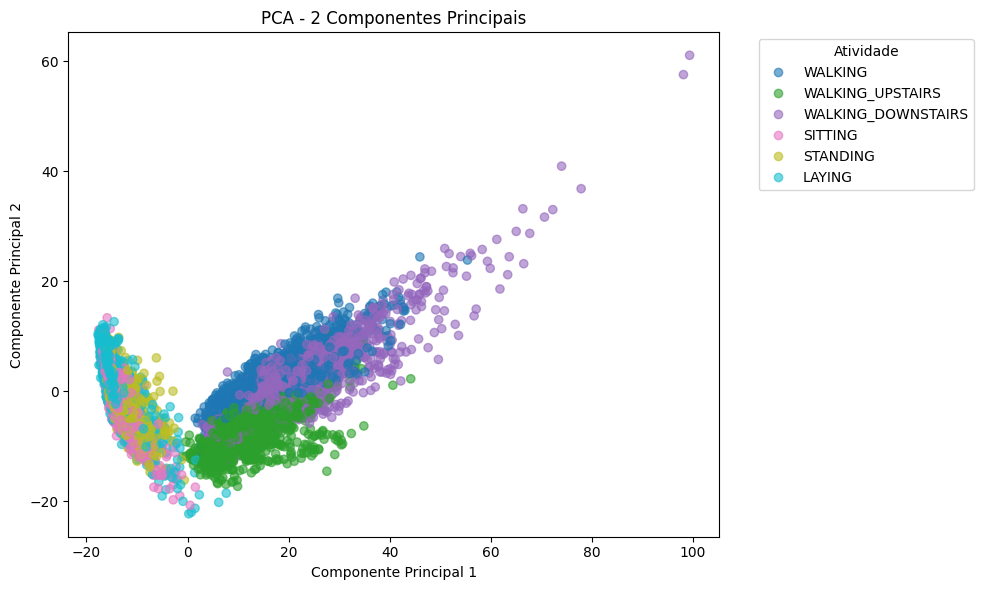

Número de componentes para >=90% da variância: 65


In [ ]:

# Aplica PCA para 2 componentes principais
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# Variância explicada pelos 2 componentes
explained_var_2 = pca_2.explained_variance_ratio_
print(f"Variância explicada pelos 2 componentes: {explained_var_2.sum():.4f}")

# Visualização 2D dos dados
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y.values.ravel(), cmap='tab10', alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - 2 Componentes Principais')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Atividade", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Determina quantos componentes explicam pelo menos 90% da variância
pca_full = PCA().fit(X_scaled)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"Número de componentes para >=90% da variância: {n_components_90}")

# Seleção de Características

### Recursive Feature Elimination (RFE)

Aplique o RFE com um classificador de sua escolha (ex.: Logistic Regression ou Random Forest).

Reduza progressivamente o número de atributos e avalie o impacto.

Identifique o subconjunto de atributos mais relevantes.

In [ ]:

# Classificador escolhido: Random Forest
clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)  # Reduz estimadores e limita profundidade para acelerar

# Avaliar impacto da redução progressiva de atributos (menos valores para acelerar)
num_features_list = [10, 50, 100, 200, 561]
scores = []
for n_features in num_features_list:
    rfe = RFE(estimator=clf, n_features_to_select=n_features, step=0.2)  # step maior para acelerar
    X_rfe = rfe.fit_transform(X_scaled, y.values.ravel())
    score = cross_val_score(clf, X_rfe, y.values.ravel(), cv=2, scoring='accuracy', n_jobs=-1).mean()  # cv=2 para acelerar
    scores.append(score)
    print(f"Atributos: {n_features}, Acurácia média: {score:.4f}")

# Identifica o melhor número de atributos
best_n = num_features_list[np.argmax(scores)]
print(f"Melhor número de atributos: {best_n} (Acurácia: {max(scores):.4f})")

# Subconjunto de atributos mais relevantes
rfe_final = RFE(estimator=clf, n_features_to_select=best_n, step=0.2)
rfe_final.fit(X_scaled, y.values.ravel())
selected_features = np.array(X.columns)[rfe_final.support_]
print("Atributos selecionados:")
print(selected_features)

Atributos: 10, Acurácia média: 0.7569
Atributos: 50, Acurácia média: 0.9052
Atributos: 50, Acurácia média: 0.9052
Atributos: 100, Acurácia média: 0.9226
Atributos: 100, Acurácia média: 0.9226
Atributos: 200, Acurácia média: 0.9288
Atributos: 200, Acurácia média: 0.9288
Atributos: 561, Acurácia média: 0.9258
Melhor número de atributos: 200 (Acurácia: 0.9288)
Atributos: 561, Acurácia média: 0.9258
Melhor número de atributos: 200 (Acurácia: 0.9288)
Atributos selecionados:
['tBodyAcc-std()-X' 'tBodyAcc-mad()-X' 'tBodyAcc-max()-X'
 'tBodyAcc-energy()-X' 'tBodyAcc-energy()-Y' 'tBodyAcc-iqr()-Y'
 'tBodyAcc-entropy()-X' 'tBodyAcc-correlation()-X,Y'
 'tBodyAcc-correlation()-X,Z' 'tBodyAcc-correlation()-Y,Z'
 'tGravityAcc-mean()-X' 'tGravityAcc-mean()-Y' 'tGravityAcc-mean()-Z'
 'tGravityAcc-std()-X' 'tGravityAcc-std()-Y' 'tGravityAcc-mad()-X'
 'tGravityAcc-mad()-Y' 'tGravityAcc-max()-X' 'tGravityAcc-max()-Y'
 'tGravityAcc-max()-Z' 'tGravityAcc-min()-X' 'tGravityAcc-min()-Y'
 'tGravityAcc-min()-Z

### Lasso (L1 Regularization) 

Aplique um modelo de regressão logística ou regressão linear com regularização L1 (Lasso).

Analise os coeficientes para identificar quais atributos foram zerados pelo modelo.

Compare o conjunto de variáveis selecionadas com o resultado do RFE.

In [ ]:
# Seleção de variáveis com Lasso (L1 Regularization)

# Modelo de regressão logística com regularização L1
lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=0.1, random_state=42, n_jobs=-1)
lasso.fit(X_scaled, y.values.ravel())

# Coeficientes do modelo
coef = lasso.coef_
if coef.ndim > 1:
    coef = coef.mean(axis=0)  # Média dos coeficientes para problemas multiclasse

# Atributos selecionados pelo Lasso
selected_lasso = np.array(X.columns)[coef != 0]
print(f"Número de atributos selecionados pelo Lasso: {len(selected_lasso)}")
print("Atributos selecionados pelo Lasso:")
print(selected_lasso)

# Comparação com RFE
print("Atributos em comum entre Lasso e RFE:")
print(set(selected_lasso) & set(selected_features))

Número de atributos selecionados pelo Lasso: 279
Atributos selecionados pelo Lasso:
['tBodyAcc-mean()-X' 'tBodyAcc-mean()-Y' 'tBodyAcc-mean()-Z'
 'tBodyAcc-std()-X' 'tBodyAcc-mad()-X' 'tBodyAcc-max()-X'
 'tBodyAcc-max()-Z' 'tBodyAcc-min()-X' 'tBodyAcc-entropy()-X'
 'tBodyAcc-entropy()-Y' 'tBodyAcc-entropy()-Z' 'tBodyAcc-arCoeff()-X,4'
 'tBodyAcc-arCoeff()-Y,4' 'tBodyAcc-arCoeff()-Z,4'
 'tBodyAcc-correlation()-X,Y' 'tBodyAcc-correlation()-X,Z'
 'tBodyAcc-correlation()-Y,Z' 'tGravityAcc-mean()-X'
 'tGravityAcc-mean()-Y' 'tGravityAcc-mean()-Z' 'tGravityAcc-std()-Z'
 'tGravityAcc-mad()-X' 'tGravityAcc-mad()-Z' 'tGravityAcc-max()-X'
 'tGravityAcc-max()-Y' 'tGravityAcc-max()-Z' 'tGravityAcc-min()-X'
 'tGravityAcc-min()-Y' 'tGravityAcc-min()-Z' 'tGravityAcc-sma()'
 'tGravityAcc-energy()-X' 'tGravityAcc-energy()-Y'
 'tGravityAcc-energy()-Z' 'tGravityAcc-iqr()-X' 'tGravityAcc-iqr()-Z'
 'tGravityAcc-entropy()-X' 'tGravityAcc-entropy()-Y'
 'tGravityAcc-entropy()-Z' 'tGravityAcc-arCoeff()-X,1'
 't

/home/emilly/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Visualizações
Gráfico de dispersão em 2D com PCA.

Gráfico da variância explicada acumulada (scree plot).

Gráfico comparando a performance do modelo ao variar o número de atributos no RFE.

Visualização dos coeficientes do Lasso (quais atributos permaneceram)

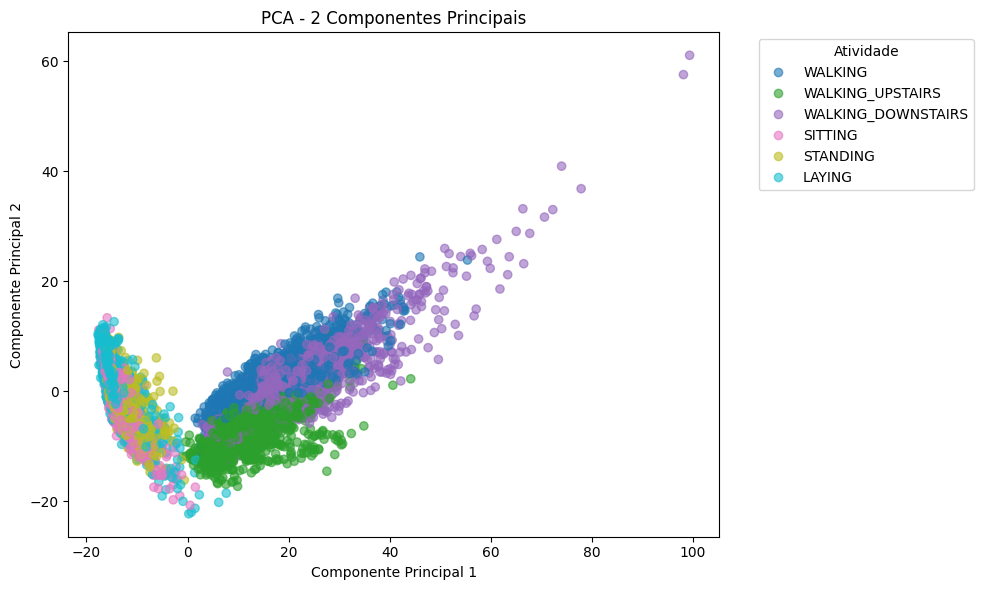

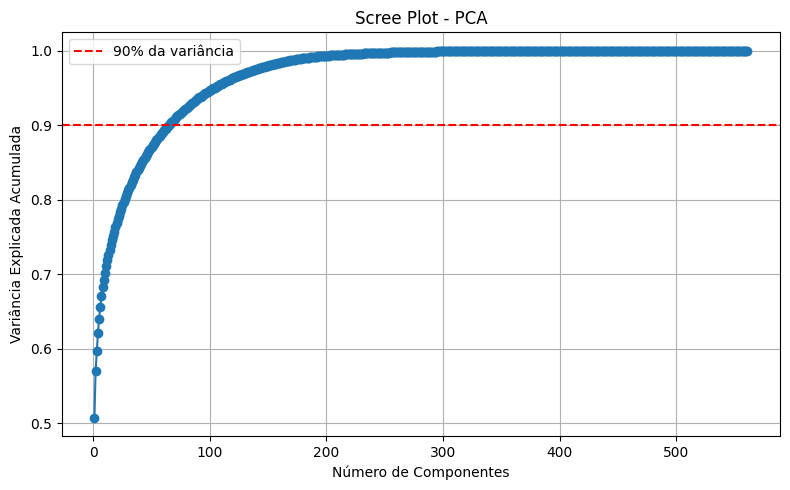

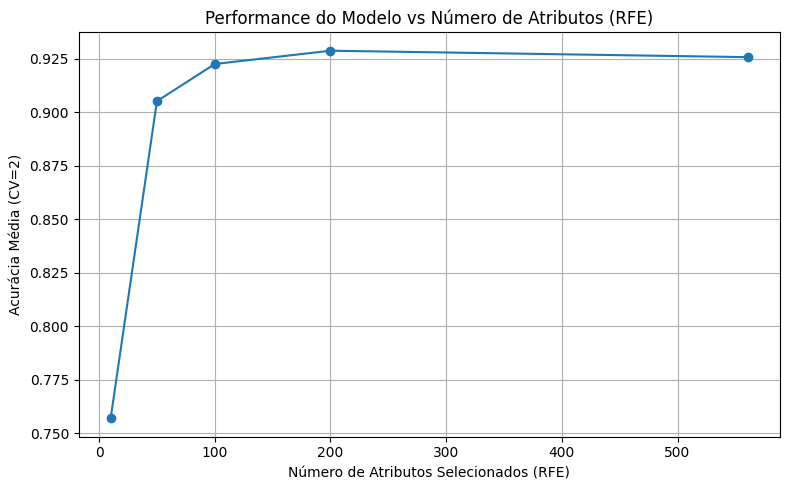

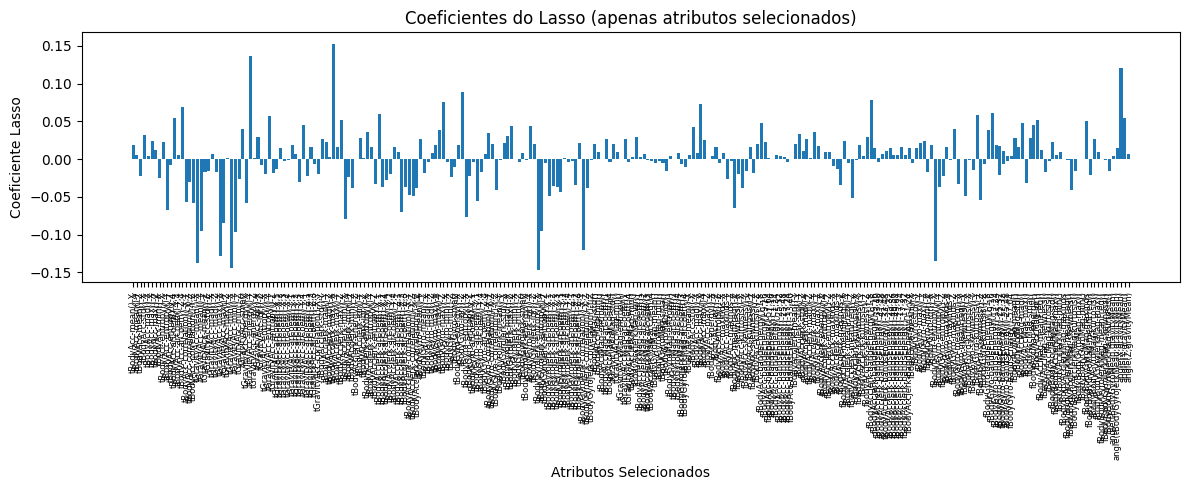

In [ ]:
# Visualizações
import matplotlib.pyplot as plt

# 1. Gráfico de dispersão em 2D com PCA
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y.values.ravel(), cmap='tab10', alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - 2 Componentes Principais')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Atividade", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Scree plot: variância explicada acumulada
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--', label='90% da variância')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Scree Plot - PCA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Performance do modelo ao variar número de atributos no RFE
plt.figure(figsize=(8,5))
plt.plot(num_features_list, scores, marker='o')
plt.xlabel('Número de Atributos Selecionados (RFE)')
plt.ylabel('Acurácia Média (CV=2)')
plt.title('Performance do Modelo vs Número de Atributos (RFE)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualização dos coeficientes do Lasso (apenas atributos selecionados)
coef_plot = coef if coef.ndim == 1 else coef.mean(axis=0)
selected_idx = np.where(coef_plot != 0)[0]
plt.figure(figsize=(12,5))
plt.bar(np.array(X.columns)[selected_idx], coef_plot[selected_idx])
plt.xlabel('Atributos Selecionados')
plt.ylabel('Coeficiente Lasso')
plt.title('Coeficientes do Lasso (apenas atributos selecionados)')
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()